In [1]:
using PyPlot
using Polynomials

In [2]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE CLASSES           ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [5]:
type Trial
    Trajectory
    Latency
    SearchPreference
    ActionMap
    Valuemap
    Error
end

type Day 
    trial::Any
    Day()=new(Trial[]);
end


type Experiment 
    day::Any
    Experiment()=new(Day[])
    PlaceCells::Any
    Platform::Any
end

type Rat
    experiment::Any
    Rat()=new(Experiment[])
    parameters
end

In [ ]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE FUNCTIONS         ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [6]:
#The algorithm places n points, of which the kth point is put at distance sqrt(k-1/2) from the boundary (index begins with k=1), and with polar angle 2*pi*k/phi^2 where phi is the golden ratio. Exception: the last alpha*sqrt(n) points are placed on the outer boundary of the circle, and the polar radius of other points is scaled to account for that. This computation of the polar radius is done in the function radius.

function  radius(k,n,b) # k index of point on the boundary, n number of total points, b number of boundary points
    if k>n-b
        r = 1;            # put on the boundary
    else
        r = sqrt(k-1/2)/sqrt(n-(b+1)/2);     # computation of radius of the different points 
    end
end

# sunflower seed arrangement :
function sunflower(n, R, alpha)   # n number of centers,
    # alpha is indicating how much one cares about the evenness of boundary , chose 2 to have nice trade off
    # R is the radius of the circle in cm
    r=Array{Any}( n);
    theta=Array{Any}( n);
    b = round(alpha*sqrt(n));      # number of boundary points
    phi = (sqrt(5)+1)/2;           # golden ratio
    
    for k=1:n
        r[k] = R*radius(k,n,b); # computation of the radius of each point 
        theta[k] = 2*pi*k/phi^2; # computation of the angle of each point 
        
        #plot(r*cos.(theta), r*sin.(theta), "m");
    end
    # scatter(r.*cos.(theta), r.*sin.(theta));#, marker='o', "m");
    X=r.*cos.(theta); 
    Y=r.*sin.(theta);
    return hcat(X, Y)
end

# Define the place activity :

# Define activity as a function of position 
###### !!!!!!! POSITIONS TO BE GIVEN IN THE SAME UNITE THAN THE SIGMA ###### !!!!!!!
function place_activity(x,y,xpc,ypc,σ) # x,y 2 scalars the position of the rat, xpc,ypc 2 vectors posiions of all place cells
    N=length(xpc); # N number of place cells 
    actplacecell=zeros(N,1); # define empty array of activity 
    
    for k=1:N # k is the k-th place cell
        actplacecell[k]=exp(-((x-xpc[k])^2+(y-ypc[k])^2)^2/(2σ^2));
    end
    return actplacecell
end 

function  placecells(position,centres,width)
# PLACECELLS Calculates the activity of the place cells in the simulation.
#
#	F = PLACECELLS(POSITION,CENTRES,WIDTH) calculates the activity of the place cells
#	in the simulation. The returned vector F is of length N, where N is the number of place
#	cells, and it contains the activity of each place cell given the simulated rat's current
#	POSITION (a 2 element column vector). The activity of the place cells is modelled as a
#	rate-of-fire (i.e. a scalar value) determined by a gaussian function. The CENTRES of the
#	gaussian functions are an argument, and must be a 2 x N matrix containing each place
#	cell's preferred location in 2D space. The WIDTH of the place cell fields must
#	also be provided as a scalar value (all place cells are assumed to have the same
#	width).
#
#	The returned vector, F, must be a N element column vector.
#
#	Code for BIO/NROD08 Assignment 2, Winter 2017
#	Author: Blake Richards, blake.richards@utoronto.ca


# calculate the place cell activity
F = exp.(-sum((repmat(position,1,size(centres,2))-centres).^2,1)/(2*width^2))';
return F
end


# Calculate reward as a function of position 
function reward(x,y,xp,yp,r) # x,y position of the rat and xp,yp position of the platform, r radius of the platform
    if (x-xp)^2+(y-yp)^2<= r^2 # if the rat is in the platform
        R=1;
    else # else 
        R=0;
    end 
    
end


# Function to return the cumulative sum of the terms of a vector : 
function cumul(A) # A vector 
    Acum=Array{Any}(length(A));
    for k=1:length(A)
       Acum[k]=sum(A[1:k]);
    
    end
    return Acum
end


# This function tells within wich index column is located x
function indice(Acum,x) # x number, Acum vector
    
    for i=1:length(Acum)
       if i==1
           if x<Acum[i]
                return i
            end
        else
            if Acum[i-1]<x<=Acum[i]
                return i
            end
        end
    end  
        
end

indice (generic function with 1 method)

In [9]:
###################################################################################
################## GENERAL THINGS THAT DONT CHANGE WITHIN TRIALS ##################
###################################################################################

# Creating the circle and the place cells:
center=[0,0];
R= 100; # Radius of the circle in cm
r=5;# Radius of the platform  in cm
radiussearchpref=20; # radius of the area in which we calculate searchpreference 

# Motion characteristic 
dt=0.1; # timestep in s 
speed=30; # speed of the rat in cm.s-1
# Different possible directions 
angles=[-3*pi/4, -2*pi/4, -pi/4, 0, pi/4, 2*pi/4, 3*pi/4, pi];


# Trial characteristic :
T=120; # maximal duration of a trial in seconds
DeltaT=15; # Interval between trials in seconds  

# Place cells 
N=493; # number of place cells 
Xplacecell=sunflower(N,R,2)[:,1]; # absciss place cells  
Yplacecell=sunflower(N,R,2)[:,2]; # y place cells 


# Place cell : method used by Blake richards 
# initialize the centres of the place cells by random unifrom sampling across the pool
arguments= rand(1,N)*2*pi;
radii= sqrt.(rand(1,N))*R;
centres= [cos.(arguments).*radii; sin.(arguments).*radii]; 
Xplacecell=centres[1,:];
Yplacecell=centres[2,:];

σ=0.30*100; # variability of place cell activity, in centimeters


# Action cells : 
n=8; # number of action cells 


# Potential positions of the platform : 
Xplatform=[0.3,0,-0.3,0,0.5,-0.5,0.5,-0.5].*R; # in cm
Yplatform=[0,0.3,0,-0.3,0.5,0.5,-0.5,-0.5].*R;# in cm

# Potential Starting positions of the rat :
Xstart=[0.95,0,-0.95,0].*R; # East, North, West, South
Ystart=[0,0.95,0,-0.95].*R;

# Define number of rats, number of days and numbers of trials per day
numberofdays=1;
numberofrats=1;
numberoftrials=20;


times=collect(0:dt:T+dt);

In [10]:

# Parameter that regulate the choice between former angle and new angle 
momentum=1.0;



# Learning variables : 
γ=0.98; # Discount factor.  they dont precise the value  
Z=0.1; # actor learning rate
W=0.01; # critic learning rate

In [11]:
#########################################################################
#############          LOOP       1   EXPERIMENT FOR 1 DAY 1 RAT   ######################
#########################################################################

rats=Rat();
rats.parameters=[momentum,γ,Z,W]; # Save different parameters 

println("start of experiments")

for indexrat=1:numberofrats
    
currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
    
# Everyday the location of the platform changes
 # Chose platform :
indexplatform=rand(1:8); # take ith platform 
xp=Xplatform[indexplatform];
yp=Yplatform[indexplatform];       
currentexperiment.Platform=hcat(xp,yp); 

# Initialisation variables :
w=zeros(N,1);
z=zeros(N,n);    
    
        ##########  ##########  ##########  ##########   ########## 
    ##########  ##########  START EXPERIMENT  ##########  ##########  
        ##########  ##########  ##########  ##########   ########## 
  
    println("start of 1 experiment")
    
    for indexday=1:numberofdays 
                    
            ##########  ##########  ##########  ##########  
        ##########  ##########  START DAY ##########  ##########  
            ##########  ##########  ##########  ##########  
            println("start of day")
        
            # Define new day   
            currentday=Day(); # creating a day 
        
        for indextrial=1:numberoftrials ##########  
            
            # Chose starting position :
            indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            positionstart=[Xstart[indexstart] Ystart[indexstart]];
            
            position=positionstart;
            
            # Initialize reward 
            re=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            # initialise time 
            t=times[k];
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
            timeout=0;        
            prevdir=[0 0];    
            ##########  ##########  ##########  ##########   ########## 
            ##########  ##########  START TRIAL ##########  ##########  
            ##########  ##########  ##########  ##########   ########## 
                println("start of trial")
            formerz=z;
            
                while t<=T && re==0
    
                        if t==T
                            X=xp;
                            Y=yp;
                            position=[X Y];
                            timeout=1; # if we have to put the rat on the platform then we dont reinforce the actor but only the critic
                        end
                        
                        
                    # Store former position to be able to draw trajectory
                    push!(historyX,position[1]) 
                    push!(historyY,position[2])
                    
                    
                         ###  Compute reward ### 
                    re=reward(position[1],position[2],xp,yp,r); 
                    
                         # compute new activity of pace cells :
                    # actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ); # this function is wrong 
                    actplacecell=placecells([position[1],position[2]],centres,σ);
                
                    ### Compute Critic ###
                    C=dot(w,actplacecell); # current estimation of the future discounted reward 
                    
                    ####### Take decision and move to new position : ########
                    # Compute the activity of action cells 
    
                    #  Compute action cell activity    
                    actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
                        if maximum(actactioncell)>=100
                            actactioncell=100.*actactioncell./maximum(actactioncell); 
                        end
                    
                    # Compute probability distribution : 
                    Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                    # be sure it does not give rise to errors by thrsholding to the maximum number allowed
                    #     for c in 1:length(Pactioncell)
                    #          if Pactioncell[c]==Inf
                    #                  Pactioncell[c]=realmax(Float64)-100;
                    #            elseif isnan(Pactioncell[c])
                    #                Pactioncell[c]=realmax(Float64)-100;
                    #           end
                    #      end
                    #
                
                    # Compute summed probability distribution:
                    SumPactioncell=cumul(Pactioncell);
                    # Generate uniform number between 0 and 1 :
                    x=rand();
                    # println(SumPactioncell)
                    # now chose action: 
                    indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                    argdecision=angles[indexaction]; # compute the coreesponding angle 
                    newdir=[cos(argdecision) sin(argdecision)];
                    dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
                    prevdir=dir;
                    # arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                    # arg=argdecision; # not good because angles too sharp
                    # Store former position 
                    formerposition=position;
                    # Compute new position : 
                    position=position.+dt.*speed.*dir; 
                    
                    X=position[1];
                    Y=position[2];
                    Xf=formerposition[1];
                    Yf=formerposition[2];
                
                    # We code walls as reflectors :
                        if X^2+Y^2>R^2 # if we are out of the circle 
                            # find the position between former position and current position that is exactly on the circle :
                            # Create Polynomial with a parameter lambda that represent the absciss along the segment
                            # search the value of lambda for which we are crossing the circle    
                            polynom=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                            # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                            λ=roots(polynom)[find(x -> 0<x <1,roots(polynom))];
                            λ=maximum(λ); # to convert from array of float to float 
                            Xlambda=λ*X+(1-λ)Xf; # position of the point that is on the circle 
                            Ylambda=λ*Y+(1-λ)Yf;
                            delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                                
                            #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                            #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                            # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                            poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);
            
                            # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                            deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                            
                                
                            # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                            Xnew=X-deplacement*Xlambda/R;
                            Ynew=Y-deplacement*Ylambda/R;
                            #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                            #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                                if Xnew^2+Ynew^2>R^2 # if we are still out of the circle 
                                    println("we are still out")
                                    break
                                end

                            X=Xnew;
                            Y=Ynew;
                            position=[X Y];    
                        end
                    
                    # If we are now at the very edge of the maze, move us in a little bit :
                        if X^2+Y^2==R^2
                            position = (position./(X^2+Y^2))*(R - 1);
                        end
                
                    # compute new activity of pace cells :
                    # actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ);
                    actplacecell=placecells([position[1],position[2]],centres,σ);

                        if re==1 # if we are on the platform 
                           ###  Compute error ###
                            Cnext=0;
                        else 
                            Cnext=dot(w,actplacecell);# new estimation of the future discounted reward 
                        end 
                    
                
                    #### Compute error  ####
                    err=re+γ*Cnext-C;
                    
               # if re==1
               #     println("timeout is $(timeout)")
               #     println("error is $(err)") 
               #     println("C is $(C)")
               # end
               #     # save error
                    push!(error,err);
                
                
                    ######### Compute new weights : ########
                        if timeout==0
                            G=zeros(8,1);
                            G[indexaction]=1;
                            # weights between action cells and place cells only reinforced when the rats actually found the platform
                            # z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                            z=z+Z.*err.*actplacecell*transpose(G);       
                        end
                    
                    # weights between critic and place cells :
                    # Save value to draw valuemap
                    # push!(valuemap,w);
                    w=w+W.*err.*actplacecell;
    
                     ####### ####### ####### Updating search preference  ####### ####### #######
                        if (X-xp)^2+(Y-yp)^2<= radiussearchpref^2          
                            searchpref=searchpref+1*dt;
                        end

                    k=k+1;
                    t=times[k];
                    println("evolution of z : $(norm(z-formerz))")
                ##################################################            
                end

                ########## ##########  END TRIAL ########## ##########             
            
            push!(historyX,position[1]) # Store the last position visited 
            push!(historyY,position[2])
            # push!(valuemap,w)
                        
            ############### SAVING THE THINGS IN THE DIFFERENT CLASS ################
            ## in creating a new trial type one should write Trial(Trajectory, latency, searchpreference, actionmap) # action map atm is just z, then it will be improved adding a new attribute being value map 
            
            currenttrial=Trial(hcat(historyX,historyY),t,searchpref,z,w,error); # Creating the current trial with all its fields

            if !(indextrial==1)
            println("difference on z : $(norm(currentday.trial[1].ActionMap-z))")
            end
            
            push!(currentday.trial,currenttrial) # Storing it in the current day 
            println(size(currentday.trial[1].ActionMap))  
        
        ##################################################     
        end 
        ########## ##########  END DAY ########## ##########
        
        
        push!(currentexperiment.day,currentday) # Storing the current day in the current experiment 
        
            
    ##################################################     
    end 
    ########## ##########  END EXPERIMENT ########## ##########

push!(rats.experiment,currentexperiment) # Storing the current experiment in the rat's class

##################################################     
end 
########## ##########  END RATS ########## ###

start of experiments
start of 1 experiment
start of day
start of trial
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolu

evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of 

evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of z : 0.0
evolution of 

evolution of z : 0.07070650577728856
evolution of z : 0.07233407928735497
evolution of z : 0.07186451509414413
evolution of z : 0.07368458147465208
evolution of z : 0.07368452529952689
evolution of z : 0.07536824985551083
evolution of z : 0.07619507936001116
evolution of z : 0.07621618440526563
evolution of z : 0.07680824558227797
evolution of z : 0.07801379252469577
evolution of z : 0.08117943473565142
evolution of z : 0.08176124762795697
evolution of z : 0.08166113919978997
evolution of z : 0.08305096230636944
evolution of z : 0.08322741331839438
evolution of z : 0.08520396554998368
evolution of z : 0.08662543419013269
evolution of z : 0.0883233455238466
evolution of z : 0.09012766051392637
evolution of z : 0.0928680288008968
evolution of z : 0.0928897428475023
evolution of z : 0.09344868410762511
evolution of z : 0.09476212394969892
evolution of z : 0.09433003035600519
evolution of z : 0.09521304321199779
evolution of z : 0.09591298373421785
evolution of z : 0.09646166491130054
evol

evolution of z : 0.051372375426320234
evolution of z : 0.05128726574407209
evolution of z : 0.05391470695969561
evolution of z : 0.05391749853874531
evolution of z : 0.05412916936182287
evolution of z : 0.05578883384074039
evolution of z : 0.05727853699161093
evolution of z : 0.05825071487645488
evolution of z : 0.05836635578553729
evolution of z : 0.05944737216494944
evolution of z : 0.06108162635799218
evolution of z : 0.06104052731974586
evolution of z : 0.06183395983233131
evolution of z : 0.06458355686198723
evolution of z : 0.06432190483376875
evolution of z : 0.06492243539338283
evolution of z : 0.06508599968210013
evolution of z : 0.0665944102553614
evolution of z : 0.06667907747333848
evolution of z : 0.06686157234514759
evolution of z : 0.06686758497755867
evolution of z : 0.06761921890133846
evolution of z : 0.06799011457507664
evolution of z : 0.06784093053399108
evolution of z : 0.06903211815419989
evolution of z : 0.07060532887622609
evolution of z : 0.07076497906535606
e

evolution of z : 0.2948025668462572
evolution of z : 0.2952221643030687
evolution of z : 0.29589937701181845
evolution of z : 0.30239255880644894
evolution of z : 0.3022030356386583
evolution of z : 0.311842088707244
evolution of z : 0.31164338249712464
evolution of z : 0.32108055230356836
evolution of z : 0.3220528010626623
evolution of z : 0.3239864139181018
evolution of z : 0.3237069540531656
evolution of z : 0.3239907955919439
evolution of z : 0.3245794615411982
evolution of z : 0.3252419418691016
evolution of z : 0.3250119164874887
evolution of z : 0.3333584302170169
evolution of z : 0.33440499611499447
evolution of z : 0.3342115373150918
evolution of z : 0.333574041866634
evolution of z : 0.3351185867914695
evolution of z : 0.33482935654388996
evolution of z : 0.3348807342664021
evolution of z : 0.3354024212247166
evolution of z : 0.3352189778021245
evolution of z : 0.3346841670805261
evolution of z : 0.3349357810180263
evolution of z : 0.335867142588499
evolution of z : 0.335355

evolution of z : 0.013354514406298895
evolution of z : 0.01344410863145254
evolution of z : 0.014710410808274062
evolution of z : 0.01862249794494909
evolution of z : 0.02478796649027194
evolution of z : 0.032733677069195555
evolution of z : 0.0420384664973753
evolution of z : 0.05238956320287119
evolution of z : 0.05238140779517283
evolution of z : 0.05926459602221383
evolution of z : 0.06852523553906512
evolution of z : 0.07916063273154056
evolution of z : 0.09054079110990129
evolution of z : 0.10222940946939535
evolution of z : 0.11389334909870992
evolution of z : 0.12525460463913224
evolution of z : 0.1360652529502447
evolution of z : 0.14609553552478138
evolution of z : 0.15512974155992137
evolution of z : 0.1629670074510921
evolution of z : 0.16942555542011514
evolution of z : 0.17434970793750187
evolution of z : 0.17761948387821766
evolution of z : 0.17916286425855324
evolution of z : 0.1789710128787554
evolution of z : 0.17711689550465998
evolution of z : 0.17377779322865122
ev

evolution of z : 0.5201128803211965
evolution of z : 0.5204068987920402
evolution of z : 0.5230040193893739
evolution of z : 0.5229568608670108
evolution of z : 0.5229646617308994
evolution of z : 0.5230720118344653
evolution of z : 0.5230783420482581
evolution of z : 0.5242052299642838
evolution of z : 0.5267338240704734
evolution of z : 0.5270426297509507
evolution of z : 0.5273639964349728
evolution of z : 0.527344330397752
evolution of z : 0.5290138636723524
evolution of z : 0.5291107931083759
evolution of z : 0.5291061105924629
evolution of z : 0.529109505721319
evolution of z : 0.5302111308081846
evolution of z : 0.5315760839705337
evolution of z : 0.533863378655065
evolution of z : 0.5341391002685266
evolution of z : 0.5368155577791648
evolution of z : 0.5367830194535433
evolution of z : 0.5367989290775466
evolution of z : 0.5378357153798271
evolution of z : 0.537872199791353
evolution of z : 0.5397009330316441
evolution of z : 0.5413063049622958
evolution of z : 0.5412807681192

evolution of z : 0.6316258049022863
evolution of z : 0.6316260185045641
evolution of z : 0.6318241404156544
evolution of z : 0.6321318806415827
evolution of z : 0.6327048991464522
evolution of z : 0.6326943398213928
evolution of z : 0.6330148332487875
evolution of z : 0.6336504844975678
evolution of z : 0.6336478194983328
evolution of z : 0.6340882943426195
evolution of z : 0.6340921185898089
evolution of z : 0.634618956097295
evolution of z : 0.6346707075496063
evolution of z : 0.6354157336867556
evolution of z : 0.6355701581429148
evolution of z : 0.636584580431006
evolution of z : 0.6377858902699891
evolution of z : 0.6398623836772122
evolution of z : 0.6400355576908304
evolution of z : 0.6413336239595154
evolution of z : 0.6413138464262349
evolution of z : 0.6413247937047912
evolution of z : 0.641449070697254
evolution of z : 0.6413877538889196
evolution of z : 0.6415085442810965
evolution of z : 0.6416058445080529
evolution of z : 0.6415589465599986
evolution of z : 0.641662568500

evolution of z : 0.6720394116660747
evolution of z : 0.6721348884997654
evolution of z : 0.6720644882179607
evolution of z : 0.6720023437215306
evolution of z : 0.6719716978483482
evolution of z : 0.6720589861531225
evolution of z : 0.6720301239559209
evolution of z : 0.672032430989772
evolution of z : 0.6723390765517102
evolution of z : 0.6728745819083236
evolution of z : 0.6729052157576491
evolution of z : 0.6729601796931718
evolution of z : 0.6729925310089878
evolution of z : 0.6733906883764625
evolution of z : 0.6734340562073244
evolution of z : 0.6739012998819742
evolution of z : 0.673940085502429
evolution of z : 0.6739388032582608
evolution of z : 0.6746650282107726
evolution of z : 0.6746260326612722
evolution of z : 0.6745939050628349
evolution of z : 0.6745571682250755
evolution of z : 0.6746938347119682
evolution of z : 0.6747440635749615
evolution of z : 0.6747254467094363
evolution of z : 0.6746589023913574
evolution of z : 0.6747895670354893
evolution of z : 0.67489829981

evolution of z : 0.6741363030624324
evolution of z : 0.674169679488644
evolution of z : 0.6742576692372428
evolution of z : 0.6745163992340488
evolution of z : 0.6745554226721071
evolution of z : 0.6746188553813744
evolution of z : 0.6746058234666931
evolution of z : 0.6745920742879135
evolution of z : 0.6746413953660269
evolution of z : 0.6746387498486586
evolution of z : 0.6746936976034513
evolution of z : 0.6749072556248511
evolution of z : 0.6749022199118001
evolution of z : 0.6749277466260186
evolution of z : 0.6749461309175011
evolution of z : 0.6749733191822026
evolution of z : 0.6752156249241078
evolution of z : 0.6752327736090173
evolution of z : 0.6752698254275024
evolution of z : 0.6752655478385828
evolution of z : 0.6753087946424345
evolution of z : 0.6752999186998134
evolution of z : 0.6753137116437606
evolution of z : 0.6753290379645605
evolution of z : 0.6753290379645605
difference on z : 0.6018920590112782
(493, 8)
start of trial
evolution of z : 0.00021821289020524558


evolution of z : 0.29332412908224553
evolution of z : 0.29330661525813934
evolution of z : 0.29370853643842226
evolution of z : 0.2964399180471735
evolution of z : 0.2964016642313143
evolution of z : 0.2985549683174178
evolution of z : 0.2985590590483943
evolution of z : 0.29959624405837976
evolution of z : 0.2995676427821145
evolution of z : 0.2997574167618957
evolution of z : 0.30005044250602625
evolution of z : 0.3005687210389394
evolution of z : 0.3006047674578265
evolution of z : 0.5658269178320512
difference on z : 0.7066567312977933
(493, 8)
start of trial
evolution of z : 6.698685549292936e-5
evolution of z : 9.133668297842602e-5
evolution of z : 0.0008790850404034177
evolution of z : 0.0022597031489068136
evolution of z : 0.004014399960858172
evolution of z : 0.006081161693874067
evolution of z : 0.006344788044468215
evolution of z : 0.008601915274062667
evolution of z : 0.009277553515726806
evolution of z : 0.011944531491537423
evolution of z : 0.015295156493851854
evolution 

evolution of z : 0.2846484133740382
evolution of z : 0.2846501509522559
evolution of z : 0.2892846071808349
evolution of z : 0.2970667184289232
evolution of z : 0.30706943878980847
evolution of z : 0.30707627135261856
evolution of z : 0.3071159188363126
evolution of z : 0.30747486354744247
evolution of z : 0.3075069837764427
evolution of z : 0.3077656167468635
evolution of z : 0.30849720795248475
evolution of z : 0.30856758595024414
evolution of z : 0.30857062298148213
evolution of z : 0.30861482705420007
evolution of z : 0.30865679300956905
evolution of z : 0.3127063857996072
evolution of z : 0.31266688427834716
evolution of z : 0.3181079449070821
evolution of z : 0.31810915940389467
evolution of z : 0.323503836571041
evolution of z : 0.32349897579200937
evolution of z : 0.32358701805726914
evolution of z : 0.32880780912534013
evolution of z : 0.3299473079027101
evolution of z : 0.33122746694774746
evolution of z : 0.3328651772745108
evolution of z : 0.3328388577493231
evolution of z 

evolution of z : 0.0043751672175896105
evolution of z : 0.012532334187256397
evolution of z : 0.02338765546010897
evolution of z : 0.024965983935170865
evolution of z : 0.036365644507867306
evolution of z : 0.050156395424888395
evolution of z : 0.06551319075032114
evolution of z : 0.0817981275964689
evolution of z : 0.09846938968420853
evolution of z : 0.11503285049652759
evolution of z : 0.13102143579224962
evolution of z : 0.14599017299422026
evolution of z : 0.1595199365700897
evolution of z : 0.17122605915279876
evolution of z : 0.18076989144291836
evolution of z : 0.18787256968010968
evolution of z : 0.1923309750816794
evolution of z : 0.19403635453734852
evolution of z : 0.19299649691921347
evolution of z : 0.18936284889603983
evolution of z : 0.18346443146407024
evolution of z : 0.18330191803538648
evolution of z : 0.27056576791619946
difference on z : 0.9660407128153671
(493, 8)
start of trial
evolution of z : 0.0010692763694345794
evolution of z : 0.002217541224935242
evolutio

evolution of z : 0.18590650732624217
evolution of z : 0.18862384751550665
evolution of z : 0.18875795236793264
evolution of z : 0.18884286907862757
evolution of z : 0.1920927354959679
evolution of z : 0.19112727260615658
evolution of z : 0.19063923231335367
evolution of z : 0.2035214102797768
evolution of z : 0.20323189645233158
evolution of z : 0.20344421094788465
evolution of z : 0.2159890053535187
evolution of z : 0.21642191332929817
evolution of z : 0.21670869033229023
evolution of z : 0.2167343559763645
evolution of z : 0.22011057017602748
evolution of z : 0.23643299577941684
evolution of z : 0.2557034364764814
evolution of z : 0.2564578451330692
evolution of z : 0.25724182343770297
evolution of z : 0.2573177658560976
evolution of z : 0.2573196650004638
evolution of z : 0.2572278750756762
evolution of z : 0.25718999195836
evolution of z : 0.26732326062065176
evolution of z : 0.26761035438909264
evolution of z : 0.26825965224429615
evolution of z : 0.26828583487264196
evolution of 

evolution of z : 0.376221026665841
evolution of z : 0.3847957873051805
evolution of z : 0.3854129469020875
evolution of z : 0.3858299041686814
evolution of z : 0.3858737512532863
evolution of z : 0.38594805560423096
evolution of z : 0.38650651342256026
evolution of z : 0.39164739485546374
evolution of z : 0.39767649151616336
evolution of z : 0.39839200252765483
evolution of z : 0.3990855130751997
evolution of z : 0.399210577999112
evolution of z : 0.4045423171726432
evolution of z : 0.4099680601369258
evolution of z : 0.4101878470210774
evolution of z : 0.41025291195910313
evolution of z : 0.41120393774567227
evolution of z : 0.41128330904358196
evolution of z : 0.4155020940813845
evolution of z : 0.42091451546981845
evolution of z : 0.4216479913869579
evolution of z : 0.42189129539303977
evolution of z : 0.4219865791781416
evolution of z : 0.4226315152696874
evolution of z : 0.4229623875715085
evolution of z : 0.4230732475529635
evolution of z : 0.4267696841749476
evolution of z : 0.4

evolution of z : 0.371531752338506
evolution of z : 0.37175249782393877
evolution of z : 0.3717643750178839
evolution of z : 0.3718865731611321
evolution of z : 0.37197386286672346
evolution of z : 0.37769118978959526
evolution of z : 0.3784016137558722
evolution of z : 0.37884844415051133
evolution of z : 0.3792836611261866
evolution of z : 0.37994381991624454
evolution of z : 0.38672390388521305
evolution of z : 0.38676679881659287
evolution of z : 0.38675717783745855
evolution of z : 0.3866330618991068
evolution of z : 0.3896077288449464
evolution of z : 0.39517091752535216
evolution of z : 0.39517266622955705
evolution of z : 0.3953871200540969
evolution of z : 0.4019316310392583
evolution of z : 0.40196432359432327
evolution of z : 0.40196068611432545
evolution of z : 0.40221384035331864
evolution of z : 0.40257095308695195
evolution of z : 0.40257530297578514
evolution of z : 0.4056528720099069
evolution of z : 0.40565768970323607
evolution of z : 0.409190110191451
evolution of z

evolution of z : 0.38804660680281583
evolution of z : 0.3951055749775425
evolution of z : 0.39520668301298156
evolution of z : 0.39519007406443735
evolution of z : 0.3954441350698558
evolution of z : 0.40203454930850435
evolution of z : 0.40211416944775297
evolution of z : 0.40982596619125433
evolution of z : 0.40984263865291953
evolution of z : 0.4101926521128976
evolution of z : 0.4106445394619882
evolution of z : 0.41574216628175925
evolution of z : 0.41590318926233233
evolution of z : 0.4162770021148868
evolution of z : 0.4224353352181772
evolution of z : 0.43347798366379237
evolution of z : 0.43340358490504105
evolution of z : 0.43345439561486493
evolution of z : 0.4404521384641
evolution of z : 0.451911187377041
evolution of z : 0.4656562337407622
evolution of z : 0.4653582509549094
evolution of z : 0.4655096991799592
evolution of z : 0.4659462468342371
evolution of z : 0.471186804941328
evolution of z : 0.4711997338496478
evolution of z : 0.4712184557567322
evolution of z : 0.47

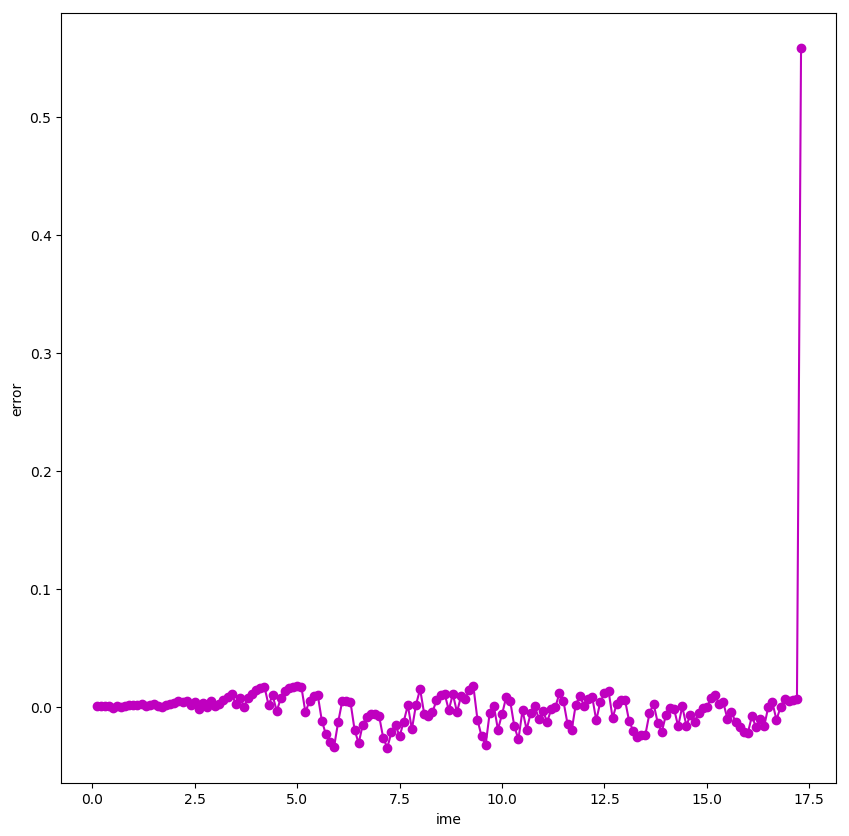

In [13]:
####### PLOT errors OF 1 RAT #######


# chose rat 
indexrat=1;
# chose Day
indexday= 1;
# chose trial
indextrial=6;

# Plot latency 
latencierat=[rats.experiment[1].day[div(k+numberoftrials-1,numberoftrials)].trial[rem(numberoftrials-1+k,numberoftrials)+1].Latency for k in 1:numberoftrials*numberofdays ]
using PyPlot
ioff()
fig = figure("Test plot latencies rat $(indexrat)",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

xlabel("ime")
ylabel("error")         

 
plot(dt:dt:rats.experiment[indexrat].day[indexday].trial[indextrial].Latency, rats.experiment[indexrat].day[indexday].trial[indextrial].Error, marker="o",linestyle="-",color="m")

show()

#using Images
#save("/Users/pmxct2/Documents/FosterDayanMorris/latency_rats$(indexrat)_parameters$(rats.parameters).eps",fig)


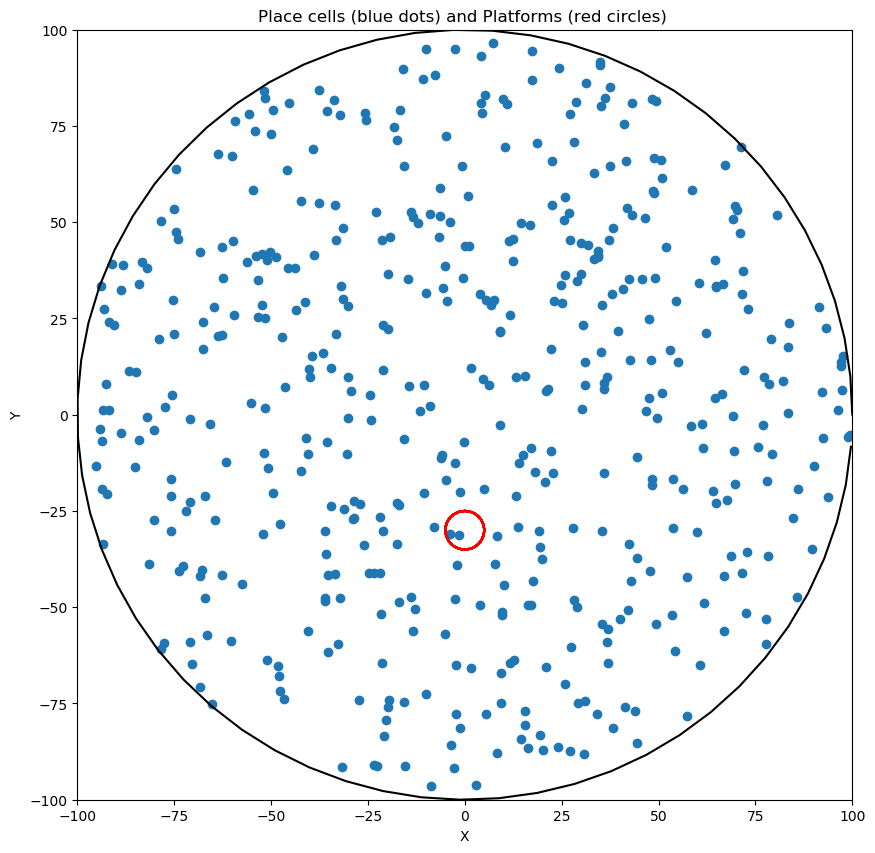

In [20]:
indexrat=1;
using PyPlot
ioff()
fig = figure("Test plot place cells",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

ax[:set_ylim]([-100,100])
ax[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")
title("Place cells (blue dots) and Platforms (red circles) ")
# place cells centers
scatter(Xplacecell ,Yplacecell)
theta=0:0.1:2*pi;
# Circle contour
plot(R*cos.(theta),R*sin.(theta),"k")
# Different position of platform
for i=1:8
plot(rats.experiment[indexrat].Platform[1]+r*cos.(theta),rats.experiment[indexrat].Platform[2]+r*sin.(theta),color="r")
plot(rats.experiment[indexrat].Platform[1]+r*cos.(theta),rats.experiment[indexrat].Platform[2]+r*sin.(theta),color="r")
plot(rats.experiment[indexrat].Platform[1]+r*cos.(theta),rats.experiment[indexrat].Platform[2]+r*sin.(theta),color="r")
plot(rats.experiment[indexrat].Platform[1]+r*cos.(theta),rats.experiment[indexrat].Platform[2]+r*sin.(theta),color="r")
end

In [18]:
###### Figure 3 Of the article remake 

# chose rat 
indexrat=1;



################## Plotting 2 trajectories  #########
using PyPlot
ioff()
fig = figure("Test plot place cells",figsize=(10,10))
ax = fig[:add_subplot](1,1,1)

ax[:set_ylim]([-100,100])
ax[:set_xlim]([-100,100])
xlabel("X")
ylabel("Y")
title("Place cells (blue dots) and Platforms (red circles) ")

scatter(Xplacecell,Yplacecell)

theta=0:0.01:2*pi;
plot(rats.experiment[indexrat].day[indexday].Platform[1]+r*cos.(theta),rats.experiment[indexrat].day[indexday].Platform[2]+r*sin.(theta),color="r")

plot(rats.experiment[indexrat].day[indexday].trial[indextrial].Trajectory[:,1],rats.experiment[indexrat].day[indexday].trial[indextrial].Trajectory[:,2],"m-", lw=2.0)

-30.0

In [4]:
using Plots, ProgressMeter
pyplot(leg=false, ticks=nothing)
x = y = linspace(-5, 5, 40)
zs = zeros(0,40)
n = 100

# create a progress bar for tracking the animation generation
prog = Progress(n,1)

@gif for i in linspace(0, 2π, n)
    f(x,y) = sin(x + 10sin(i)) + cos(y)

    # create a plot with 3 subplots and a custom layout
    l = @layout [a{0.7w} b; c{0.2h}]
    p = plot(x, y, f, st = [:surface, :contourf], layout=l)

    # induce a slight oscillating camera angle sweep, in degrees (azimuth, altitude)
    plot!(p[1],camera=(15*cos(i),40))

    # add a tracking line
    fixed_x = zeros(40)
    z = map(f,fixed_x,y)
    plot!(p[1], fixed_x, y, z, line = (:black, 5, 0.2))
    vline!(p[2], [0], line = (:black, 5))

    # add to and show the tracked values over time
    zs = vcat(zs, z')
    plot!(p[3], zs, alpha = 0.2, palette = cgrad(:blues).colors)

    # increment the progress bar
    next!(prog)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:01:41
ImageMagick can be installed by executing `Pkg.add("ImageMagick")`.
You may also need to install the imagemagick c++ library through your operating system.
Will try ffmpeg, but it's lower quality...)


LoadError: [91mcould not spawn `ffmpeg -v 0 -framerate 20 -loop 0 -i /var/folders/0b/vqp594gs0lz109m2cg4swvg40000gq/T/tmpjNAFke/%06d.png -y /Users/pmxct2/Documents/FosterDayanMorris/tmp.gif`: no such file or directory (ENOENT)[39m